In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

C:\Users\Admin\AppData\Local\Temp\ipykernel_3564\2216647736.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep = ";")

# remove rows with outliers
data = data[data["total sulfur dioxide"] < 200]

# z score all variables except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop("quality")
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data["boolQuality"] = 0
# data["boolQuality"][data["quality"] < 6] = 0 # implicit in the code
data["boolQuality"][data["quality"] > 5] = 1

C:\Users\Admin\AppData\Local\Temp\ipykernel_3564\3910500996.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["boolQuality"][data["quality"] > 5] = 1
C:\Users\Admin\AppData\Local\Temp\ipykernel_3564\3910500996.py:15: SettingWithCopyW

In [5]:
# convert from pandas dataframe to tensor
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data["boolQuality"].values).float()
# we'll actually need the labels to be a tensor
labels = labels[:, None]

train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size = .2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset = TensorDataset(test_data, test_labels)

In [7]:
# create a class for this model

class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer
        self.input = nn.Linear(11, 16)
    
        # hidden layer
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)
    
        # output layer
        self.output = nn.Linear(32, 1)

    # forward pass
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x)) # fc = fully connected
        x = F.relu(self.fc2(x))
        return self.output(x)

In [10]:
 # train the model

# training parameter
numepochs = 1000

def trainTheModel():
    trainAcc = []
    testAcc = []
    losses = torch.zeros(numepochs)

    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr = .01)
    
    # train the model
    for epochi in range(numepochs):

        # activate training mode
        winenet.train()
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # get avg losses over the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        winenet.eval() # activate testing mode
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        with torch.no_grad(): # deactivates auto grad
            yHat = winenet(X)

        # compute test accuracy
        testAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
        
    # function output
    return trainAcc, testAcc, losses

In [11]:
# range of batch sizes
batchsizes = 2**np.arange(1, 10, 2)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(batchsizes)))
accuracyResultsTest = np.zeros((numepochs, len(batchsizes)))
comptime = np.zeros(len(batchsizes))

# test data doesn't vary by training batch size
test_loader = DataLoader(test_dataDataset, batch_size = test_dataDataset.tensors[0].shape[0])

# loop over batch sizes
for bi in range(len(batchsizes)):

    # start the clock
    starttime = time.process_time()
    
    # create dataLoader object
    train_loader = DataLoader(train_dataDataset, batch_size = int(batchsizes[bi]), shuffle = True, drop_last = True)
    
    # create and train a model
    winenet = ANNwine()
    trainAcc, testAcc, losses = trainTheModel()

    # store data
    accuracyResultsTrain[:, bi] = trainAcc
    accuracyResultsTest[:, bi] = testAcc

    # check the timer
    comptime[bi] = time.process_time() - starttime

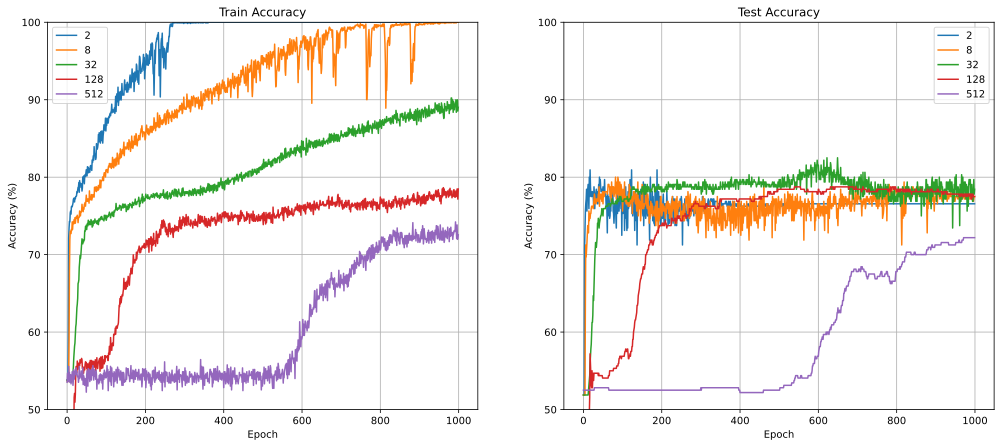

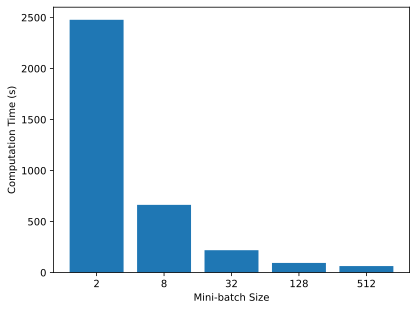

In [13]:
# plot some results
fig, ax = plt.subplots(1, 2, figsize = (17, 7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title("Train Accuracy")
ax[1].plot(accuracyResultsTest)
ax[1].set_title("Test Accuracy")

# common features
for i in range(2):
    ax[i].legend(batchsizes)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([50, 100])
    ax[i].grid()

plt.show()

# bar plot of computation time
plt.bar(range(len(comptime)), comptime, tick_label = batchsizes)
plt.xlabel("Mini-batch Size")
plt.ylabel("Computation Time (s)")
plt.show()